## Compare LightGBM in the case of binary class (Sell, Buy)

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_lightgbm,
    select_threshold,
)

In [2]:
METRIC = "roc_auc"
TEST_SIZE = 500
FPR_MAX = 0.001
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [10]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC, 12),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-17 03:07:15,503] A new study created in memory with name: no-name-ccb76d56-ba16-468c-88e9-a2c0ea7d2b92


[I 2024-02-17 03:07:16,536] Trial 0 finished with value: 0.5449089733808576 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9412660193861806, 'feature_fraction_bynode': 0.700901728913941, 'bagging_fraction': 0.40951542213203884, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 6, 'extra_trees': True}. Best is trial 0 with value: 0.5449089733808576.
[I 2024-02-17 03:07:17,183] Trial 1 finished with value: 0.5396706465301944 and parameters: {'lambda_l1': 6.783994694771757e-05, 'lambda_l2': 0.005409181413953853, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9899342275785848, 'feature_fraction_bynode': 0.7250470433988445, 'bagging_fraction': 0.3802247462577368, 'bagging_freq': 3, 'min_child_samples': 79, 'num_grad_quant_bins': 11, 'max_depth': 5, 'extra_trees': True}. Best is tri

Number of finished trials: 150
Best trial:
  Value: 0.7234943324257431
  Params: 
    lambda_l1: 0.0006282822340391826
    lambda_l2: 9.798168904163548
    num_leaves: 220
    min_sum_hessian_in_leaf: 0.0020092339949773635
    feature_fraction: 0.7705398269536793
    feature_fraction_bynode: 0.4950764646759994
    bagging_fraction: 0.9879499782519062
    bagging_freq: 4
    min_child_samples: 7
    num_grad_quant_bins: 9
    max_depth: 16
    extra_trees: False


In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **trial.params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [12]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9879499782519062,
                                bagging_freq=4, extra_trees=False,
                                feature_fraction=0.7705398269536793,
                                feature_fraction_bynode=0.4950764646759994,
                                lambda_l1=0.0006282822340391826,
                                lambda_l2=9.798168904163548, max_depth=16,
                                metric='average_precision', min_child_samples=7,
                                min_sum_hessian_in_leaf=0.0020092339949773635,
                                num_grad_quant_bins=9, num_leaves=220,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [13]:
# In-sample score
pipe.score(X_train, y_train)

0.9494047619047619

In [14]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       477
           1       0.94      0.96      0.95       531

    accuracy                           0.95      1008
   macro avg       0.95      0.95      0.95      1008
weighted avg       0.95      0.95      0.95      1008



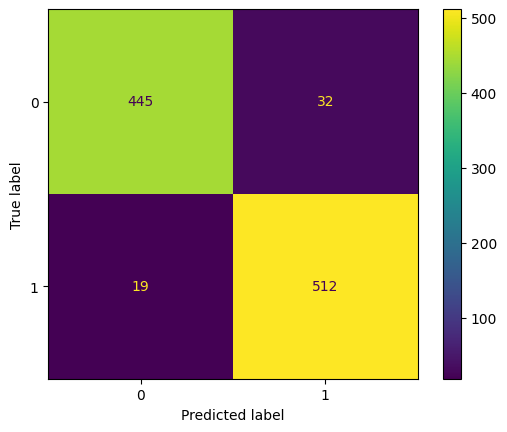

In [15]:
display_report(y_train, in_sample_preds)

In [16]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.69


In [17]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [18]:
pipe.score(X_test, y_test)

0.424

              precision    recall  f1-score   support

           0       0.59      0.21      0.31       299
           1       0.40      0.79      0.53       201

    accuracy                           0.44       500
   macro avg       0.50      0.50      0.42       500
weighted avg       0.52      0.44      0.40       500



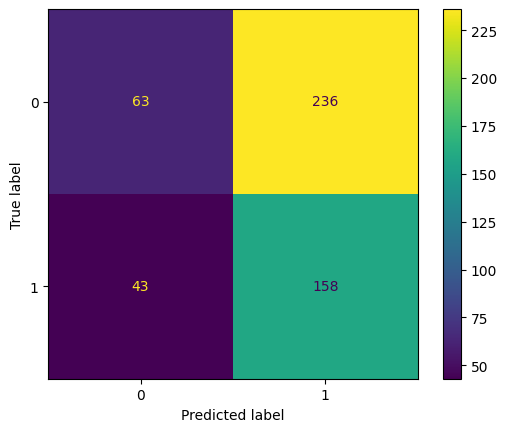

In [19]:
display_report(y_test, predictions)

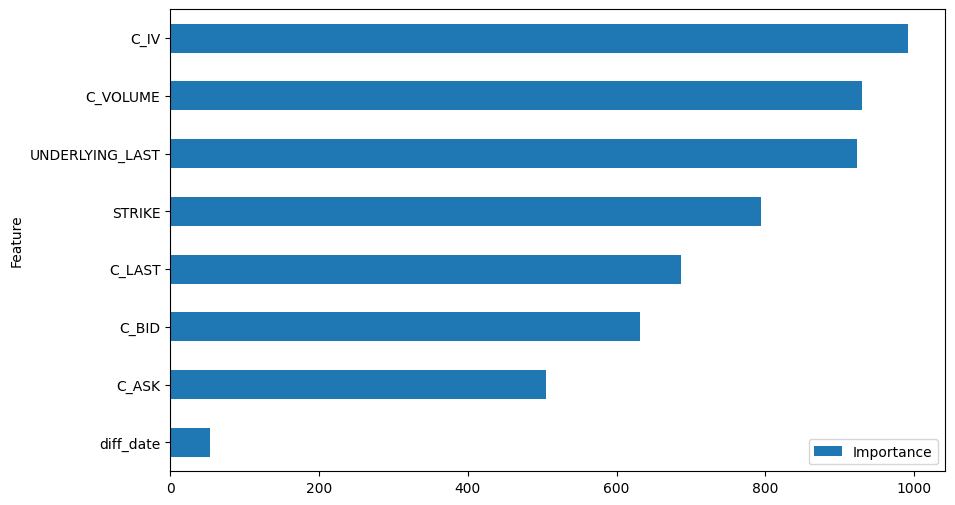

In [20]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [21]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [22]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [23]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-11,0,470.0,6.01,2022-01-31,449.910004,0.0,-6.010000,0.000000,-6.010000
2022-01-12,0,470.0,6.99,2022-02-02,457.350006,0.0,-6.990000,0.000000,-13.000000
2022-01-13,0,465.0,6.84,2022-02-02,457.350006,0.0,-6.840000,0.000000,-19.840000
2022-01-14,0,465.0,7.14,2022-02-04,448.700012,0.0,-7.140000,0.000000,-26.980000
2022-01-17,0,465.0,7.42,2022-02-07,447.260010,0.0,-7.420000,0.000000,-34.400000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,19.139946,26.509847
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.0,0.309993,19.139946,26.819840
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,19.139946,27.059833


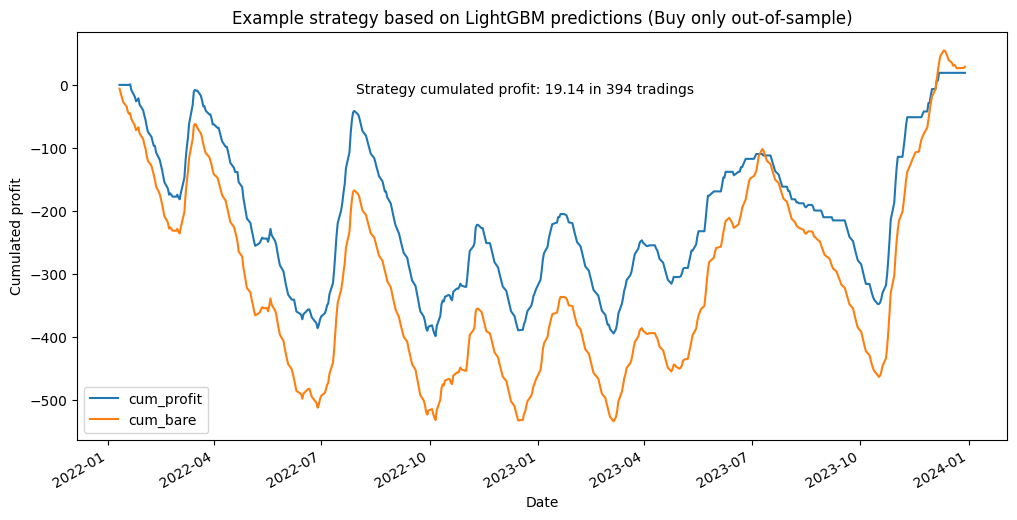

In [24]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [25]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [26]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [27]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [29]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC, 12),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-17 03:09:32,070] A new study created in memory with name: no-name-0f241b2d-9d9c-4558-b7ae-2dc2db5f8f0c


[I 2024-02-17 03:09:33,904] Trial 0 finished with value: 0.5659247520515354 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9412660193861806, 'feature_fraction_bynode': 0.700901728913941, 'bagging_fraction': 0.40951542213203884, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 6, 'extra_trees': True}. Best is trial 0 with value: 0.5659247520515354.
[I 2024-02-17 03:09:34,431] Trial 1 finished with value: 0.5660892333388082 and parameters: {'lambda_l1': 6.783994694771757e-05, 'lambda_l2': 0.005409181413953853, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9899342275785848, 'feature_fraction_bynode': 0.7250470433988445, 'bagging_fraction': 0.3802247462577368, 'bagging_freq': 3, 'min_child_samples': 79, 'num_grad_quant_bins': 11, 'max_depth': 5, 'extra_trees': True}. Best is tri

Number of finished trials: 150
Best trial:
  Value: 0.8088152452070162
  Params: 
    lambda_l1: 0.06269283396248164
    lambda_l2: 7.858723492125877e-06
    num_leaves: 216
    min_sum_hessian_in_leaf: 0.008976196912602251
    feature_fraction: 0.34994980234267914
    feature_fraction_bynode: 0.3393929359069973
    bagging_fraction: 0.9177825427581223
    bagging_freq: 2
    min_child_samples: 5
    num_grad_quant_bins: 11
    max_depth: 15
    extra_trees: False


In [30]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **study.best_params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [31]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9177825427581223,
                                bagging_freq=2, extra_trees=False,
                                feature_fraction=0.34994980234267914,
                                feature_fraction_bynode=0.3393929359069973,
                                lambda_l1=0.06269283396248164,
                                lambda_l2=7.858723492125877e-06, max_depth=15,
                                metric='average_precision', min_child_samples=5,
                                min_sum_hessian_in_leaf=0.008976196912602251,
                                num_grad_quant_bins=11, num_leaves=216,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [32]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [33]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       477
           1       1.00      1.00      1.00       531

    accuracy                           1.00      1008
   macro avg       1.00      1.00      1.00      1008
weighted avg       1.00      1.00      1.00      1008



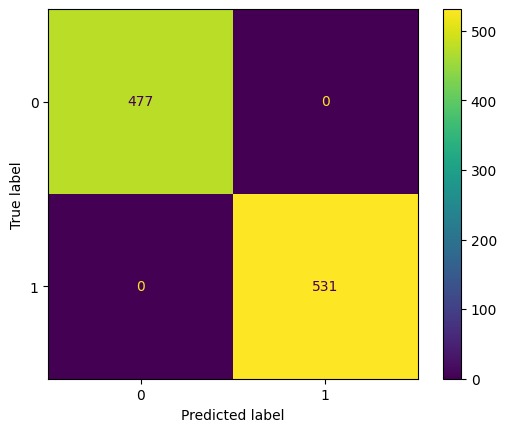

In [34]:
display_report(y_train, in_sample_preds)

In [35]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.91


In [36]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [37]:
pipe.score(X_test, y_test)

0.44

              precision    recall  f1-score   support

           0       0.72      0.34      0.47       299
           1       0.45      0.80      0.58       201

    accuracy                           0.53       500
   macro avg       0.59      0.57      0.52       500
weighted avg       0.61      0.53      0.51       500



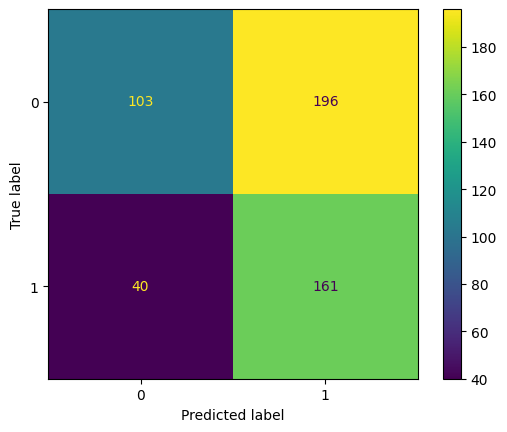

In [38]:
display_report(y_test, predictions)

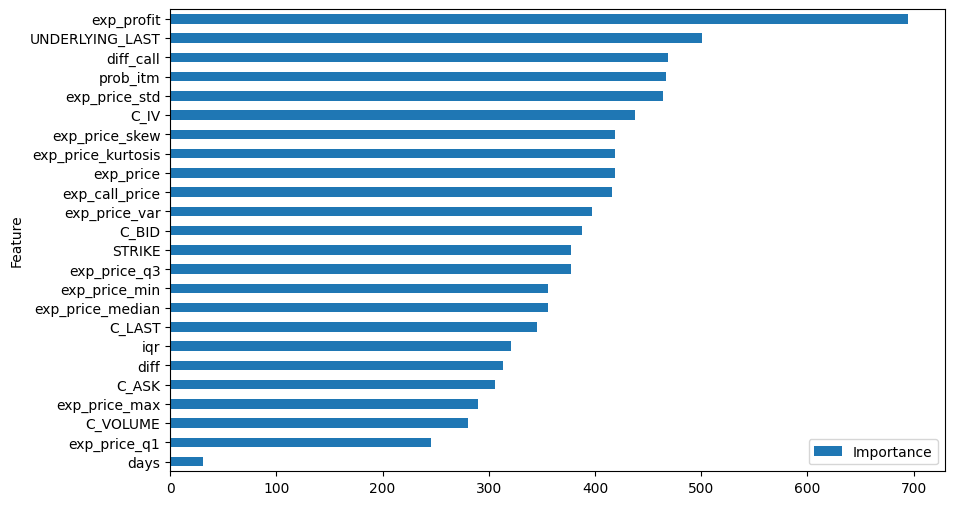

In [39]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [40]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [41]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [42]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-11,0,470.0,6.01,2022-01-31,449.910004,0.0,-6.010000,0.000000,-6.010000
2022-01-12,0,470.0,6.99,2022-02-02,457.350006,0.0,-6.990000,0.000000,-13.000000
2022-01-13,0,465.0,6.84,2022-02-02,457.350006,0.0,-6.840000,0.000000,-19.840000
2022-01-14,0,465.0,7.14,2022-02-04,448.700012,0.0,-7.140000,0.000000,-26.980000
2022-01-17,0,465.0,7.42,2022-02-07,447.260010,0.0,-7.420000,0.000000,-34.400000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,282.739961,26.509847
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.0,0.309993,282.739961,26.819840
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,282.739961,27.059833


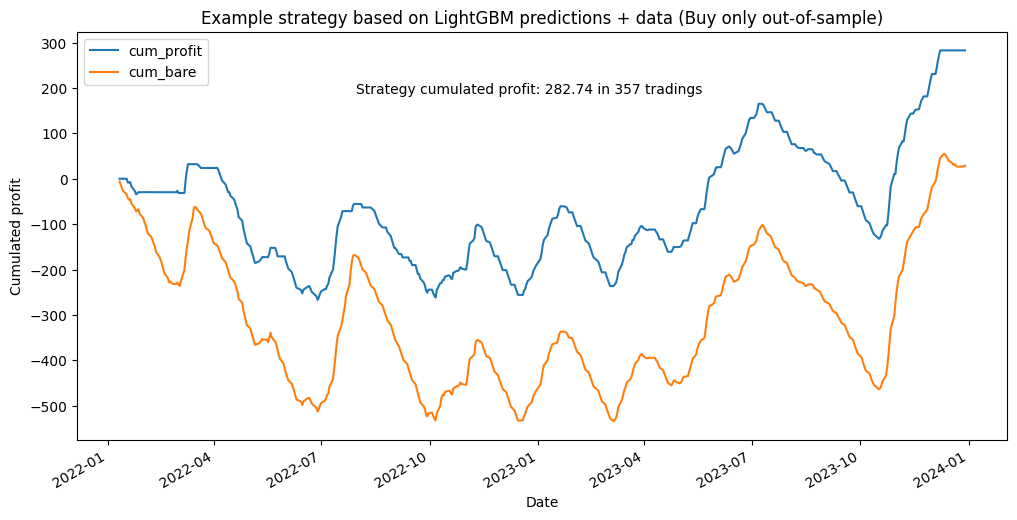

In [43]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [44]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [45]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [46]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
5,0,0.000000,1,-8.220000,-42.620000
13,1,-31.329999,0,-29.549999,-77.259990
14,1,-40.169999,0,-29.549999,-86.099990
15,1,-48.689999,0,-29.549999,-94.619990
16,1,-55.329999,0,-29.549999,-101.259990
...,...,...,...,...,...
473,0,-51.350017,1,163.560022,-95.590054
474,0,-51.350017,1,172.340009,-86.810067
478,0,-28.720037,1,208.649983,-40.720106
483,0,6.879949,1,259.729966,22.679871


In [47]:
compare_df[mask_out].shape

(157, 5)

In [48]:
compare_df.sum(axis=0)

bare_rf_pred_out          394.000000
cum_profit_out        -104701.600868
mmar_rf_pred_out          357.000000
mmar_cum_profit_out    -32350.966957
mmar_cum_bare_out     -153910.617899
dtype: float64

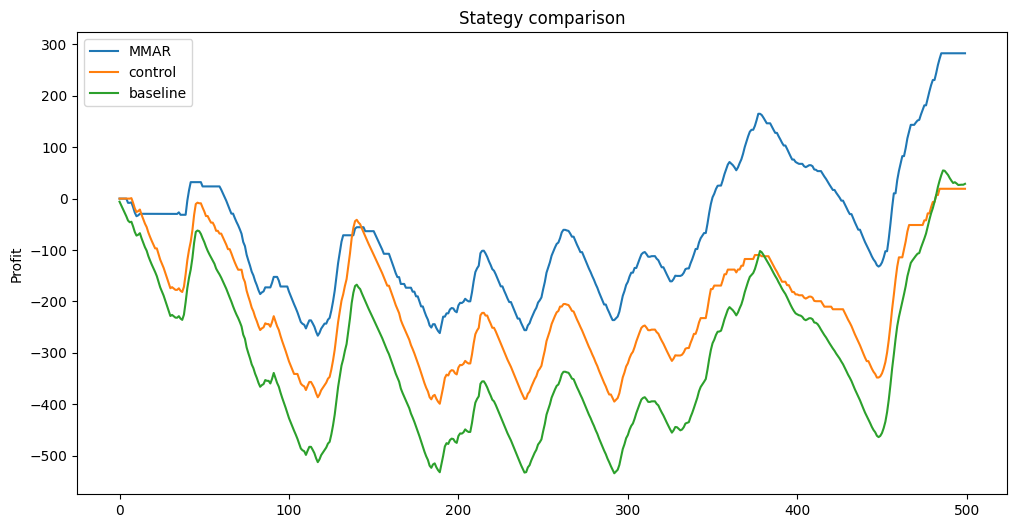

In [49]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()